In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme(style='dark', palette = 'pastel')

import spotipy
from spotipy.oauth2 import SpotifyOAuth

import os
from IPython.display import Image, display

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.problem_transform import BinaryRelevance
from scipy.spatial.distance import cosine

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer

import xgboost as xgb
#from catboost import CatBoostClassifier

from textblob import TextBlob
import pickle

In [203]:
scope = "user-top-read"
sp = spotipy.Spotify(
        auth_manager=spotipy.SpotifyOAuth(    
          scope=scope, open_browser=False))

# 1. Preparation

## 1.1 Audio features in Spotify's API

**acousticness**
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**danceability**
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**duration_ms**
The duration of the track in milliseconds.

**energy**
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**instrumentalness**
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**key**
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

**liveness**
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**loudness**
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

**mode**
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**speechiness**
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**tempo**
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

**time_signature**
An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

**valence**
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

## 1.2 Moods

We choose the moods according to Thayer's model for the emotional plane:

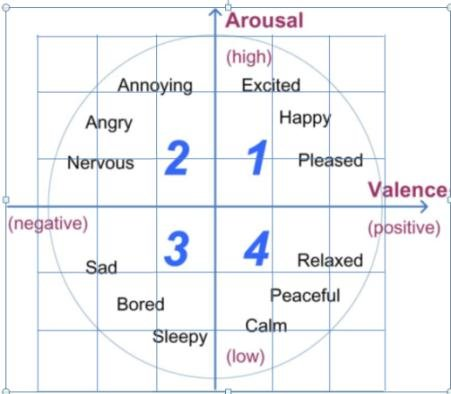

In [ ]:
Image("Thayers-Model-for-the-Emotional-Plane-also-named-Russels-model.png")

The moods we settle on are **angry**, happy/energetic(=**feelgood**), **calm** and **sad**.

Technically, only valence and energy should be enough to classify moods because they are the identifiers of our 4 different moods. However, as data is not perfect, we need more features.

# 2. Data collection

In [ ]:
# a collection of several playlists as full links

angry = ["https://open.spotify.com/playlist/37i9dQZF1EIgNZCaOGb0Mi?si=6408218e81a04a35",
        "https://open.spotify.com/playlist/5s7Sp5OZsw981I2OkQmyrz?si=c1c6f96a70754395",
        "https://open.spotify.com/playlist/7E527WhOmpTrdwwnUzkmAD?si=b74886f99bbb45c9",
        "https://open.spotify.com/playlist/77u4SHd1TQSIMa3rtGFr6O?si=22950e90eeb44a4d",
        "https://open.spotify.com/playlist/4mJCRik4FVLtaSVccmBTzy?si=f2650503e9944b5b",
        "https://open.spotify.com/playlist/4byNu3ZWic9R7OgfT8jBFM?si=f7ab55795f3d4180",
         "https://open.spotify.com/playlist/37i9dQZF1DXdfpzpMlZqi7?si=4d452f184acc4afc",
         "https://open.spotify.com/playlist/6ttyvOfJNe422gpNA00Qc2?si=1d78612fbb2c4e2d",
         "https://open.spotify.com/playlist/37i9dQZF1DX1zG0qRnyaQ3?si=9d0ed2c991d4451e",
         "https://open.spotify.com/playlist/37i9dQZF1EIcpc1Z28flXB?si=e15ae7f757d0435e"]

feelgood = ["https://open.spotify.com/playlist/37i9dQZF1DX21sNa02ZMU9?si=77fbe137e40e461e",
           "https://open.spotify.com/playlist/37i9dQZF1DX64nnRPoKA6J?si=cfda2748a2c04027",
           "https://open.spotify.com/playlist/37i9dQZF1DX5wgkIjaIMie?si=90a77ad7606f473d",
           "https://open.spotify.com/playlist/37i9dQZF1DXbdTzLVot2nl?si=a9072c73966c4489",
           "https://open.spotify.com/playlist/37i9dQZF1DX3rxVfibe1L0?si=2dff37baf5964d32",
           "https://open.spotify.com/playlist/37i9dQZF1DWYBO1MoTDhZI?si=25d467ae8b7e4487",
           "https://open.spotify.com/playlist/37i9dQZF1DX2SK4ytI2KAZ?si=e92b45222b784382",
           "https://open.spotify.com/playlist/37i9dQZF1DXdPec7aLTmlC?si=35a9d7a0b84d4bb4"
           "https://open.spotify.com/playlist/37i9dQZF1DXc5e2bJhV6pu?si=7fbf562d3788401a",
            "https://open.spotify.com/playlist/37i9dQZF1DX0E9XMGembJo?si=d1302726feec479b"]

sad = ["https://open.spotify.com/playlist/37i9dQZF1DX8Vz2ROLXhTT?si=41312f96adcb4f56",
      "https://open.spotify.com/playlist/37i9dQZF1DXa39zZwdBPSN?si=22513f6c624e4fbe",
      "https://open.spotify.com/playlist/37i9dQZF1DWZFicI79sEj9?si=24c2a1af2c834b39",
      "https://open.spotify.com/playlist/37i9dQZF1DXaS0Bb5SeHIi?si=7a9e820267ee4978",
      "https://open.spotify.com/playlist/37i9dQZF1DX46zHlTTyolY?si=17ba37babd594871",
      "https://open.spotify.com/playlist/37i9dQZF1DX9LT7r8qPxfa?si=60825ea8a5444602",
      "https://open.spotify.com/playlist/37i9dQZF1DX3YSRoSdA634?si=d30345f976e04d5b",
      "https://open.spotify.com/playlist/37i9dQZF1DX59NCqCqJtoH?si=19c300e7f65f4c34",
       "https://open.spotify.com/playlist/37i9dQZF1DX15JKV0q7shD?si=c40d8d05f8604906",
       "https://open.spotify.com/playlist/37i9dQZF1DX30gKInBBe5k?si=7c538420ac1e4afe"]

calm = ["https://open.spotify.com/playlist/37i9dQZF1DWZ0OzPeadl0h?si=6e70994173024ba9",
       "https://open.spotify.com/playlist/37i9dQZF1DX5bjCEbRU4SJ?si=2621c19d2a654352",
       "https://open.spotify.com/playlist/37i9dQZF1DX0x36cwEyOTG?si=b2b4035ec92e424c",
       "https://open.spotify.com/playlist/37i9dQZF1DXci7j0DJQgGp?si=384fd8d4fb064bbd", 
       "https://open.spotify.com/playlist/37i9dQZF1DWYoDXiQsd3D2?si=852a1528f15d4fec",
       "https://open.spotify.com/playlist/37i9dQZF1DWU0ScTcjJBdj?si=7e0ce5f520134c91",
       "https://open.spotify.com/playlist/37i9dQZF1DXaIrEwuQ3hyy?si=dc26a377de28455f",
       "https://open.spotify.com/playlist/37i9dQZF1DWVgfADJapICT?si=b71223d1095f45ff",
        "https://open.spotify.com/playlist/43Q9LvUErcQvo4YzG2wd5k?si=d9666917cdcd46f8",
        "https://open.spotify.com/playlist/37i9dQZF1DX2n5hpuulC75?si=c9404bc798f748fb"] 




In [ ]:
#Take the ids out and create a dict containing all information

playlist_dict = {
    'angry' : ["37i9dQZF1EIgNZCaOGb0Mi",
        "5s7Sp5OZsw981I2OkQmyrz",
        "7E527WhOmpTrdwwnUzkmAD",
        "77u4SHd1TQSIMa3rtGFr6O",
        "4mJCRik4FVLtaSVccmBTzy",
        "4byNu3ZWic9R7OgfT8jBFM",
        "37i9dQZF1DXdfpzpMlZqi7",
        "6ttyvOfJNe422gpNA00Qc2",
        "37i9dQZF1DX1zG0qRnyaQ3",
        "37i9dQZF1EIcpc1Z28flXB"],

'feelgood' : ["37i9dQZF1DX21sNa02ZMU9",
           "37i9dQZF1DX64nnRPoKA6J",
           "37i9dQZF1DX5wgkIjaIMie",
           "37i9dQZF1DXbdTzLVot2nl",
           "37i9dQZF1DX3rxVfibe1L0",
           "37i9dQZF1DWYBO1MoTDhZI",
           "37i9dQZF1DX2SK4ytI2KAZ",
           "37i9dQZF1DXdPec7aLTmlC",
           "37i9dQZF1DXc5e2bJhV6pu",
           "37i9dQZF1DX0E9XMGembJo"],

'sad' : ["37i9dQZF1DX8Vz2ROLXhTT",
      "37i9dQZF1DXa39zZwdBPSN",
      "37i9dQZF1DWZFicI79sEj9",
      "37i9dQZF1DXaS0Bb5SeHIi",
      "37i9dQZF1DX46zHlTTyolY",
      "37i9dQZF1DX9LT7r8qPxfa",
      "37i9dQZF1DX3YSRoSdA634",
      "37i9dQZF1DX59NCqCqJtoH",
      "37i9dQZF1DX15JKV0q7shD",
      "37i9dQZF1DX30gKInBBe5k"],

'calm' : ["37i9dQZF1DWZ0OzPeadl0h",
       "37i9dQZF1DX5bjCEbRU4SJ",
       "37i9dQZF1DX0x36cwEyOTG",
       "37i9dQZF1DXci7j0DJQgGp",
       "37i9dQZF1DWYoDXiQsd3D2",
       "37i9dQZF1DWU0ScTcjJBdj",
       "37i9dQZF1DXaIrEwuQ3hyy",
       "37i9dQZF1DWVgfADJapICT",
       "43Q9LvUErcQvo4YzG2wd5k",
       "37i9dQZF1DX2n5hpuulC75"]   
}

In [ ]:
playlist_dict.keys()

dict_keys(['angry', 'feelgood', 'sad', 'calm'])

In [ ]:
def df_from_playlist(playlist_dict):

  """
  This function returns a dataframe containing track, artist and audio information about songs in a playlist.
  Input: A dictionary with a mood (angry, sad, feelgood, calm) as key and a list of spotify playlist ids as values (e.g 37i9dQZF1DX2n5hpuulC75)


  Warning: As there are several API calls going on (for playlist, tracks, artist and audio features) this function runs for a while. Grab a coffee!
  """




  data_dict = {
    "id":[],  
    "track_name":[], 
    "artist_name":[],
    "artist_pop":[],
    "artist_genres":[],
    "album":[],
    "track_pop":[],
    "valence":[], 
    "energy":[],
    "danceability":[],
    "loudness" :[],
    "speechiness":[],
    "acousticness":[],
    "instrumentalness":[],
    "liveness":[],
    "mode":[],
    "key":[],
    "tempo":[],
    "duration_ms":[],
    "time_signature":[],
    "mood":[],
  }


  
  for key, value in playlist_dict.items():
    for i in playlist_dict[key]:
      for track in sp.playlist_tracks(i)["items"]:
    
    #Track Id and mood
        data_dict["id"].append(track["track"]["id"])
        data_dict["mood"].append(key)
    
    #Track and artist information
        #track_meta = sp.track(track["track"]["id"])
        data_dict["track_name"].append(track["track"]["name"])
        artist_uri = track["track"]["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri)
        #data_dict["artist_name"].append(track_meta["album"]["artists"][0]["name"])

        data_dict["artist_name"].append(track["track"]["artists"][0]["name"])
        data_dict["artist_pop"].append(artist_info["popularity"])
          
        if len(artist_info["genres"]) != 0: #conditional on there being genres
            data_dict["artist_genres"].append(artist_info["genres"][0]) 
        else:
            data_dict["artist_genres"].append("unknown")
        

        #Album
        data_dict["album"].append(track["track"]["album"]["name"])

        #Popularity of the track
        data_dict["track_pop"].append(track["track"]["popularity"])
        

        #Audio features
        track_features = sp.audio_features(track["track"]["id"])[0]
        data_dict["valence"].append(track_features["valence"])
        data_dict["energy"].append(track_features["energy"])
        data_dict["danceability"].append(track_features["danceability"])
        data_dict["loudness"].append(track_features["loudness"])
        data_dict["speechiness"].append(track_features["speechiness"])
        data_dict["acousticness"].append(track_features["acousticness"])
        data_dict["instrumentalness"].append(track_features["instrumentalness"])
        data_dict["liveness"].append(track_features["liveness"])
        data_dict["mode"].append(track_features["mode"])
        data_dict["key"].append(track_features["key"])
        data_dict["tempo"].append(track_features["tempo"])
        data_dict["duration_ms"].append(track_features["duration_ms"])
        data_dict["time_signature"].append(track_features["time_signature"])


  # Store data in pandas dataframe
  analysis_df = pd.DataFrame(data_dict)

  # Drop duplicates
  analysis_df.drop_duplicates(subset = "id", keep = "first", inplace = True)
  return analysis_df

In [ ]:
final_df = df_from_playlist(playlist_dict)

In [ ]:
final_df.to_csv("spotify_api_data_full.csv")

# 3. EDA

In [22]:
analysis_df = pd.read_csv('/content/spotify_api_data_full.csv', index_col=0)

In [8]:
analysis_df

,id,track_name,artist_name,artist_pop,artist_genres,album,track_pop,valence,energy,danceability,...,speechiness,acousticness,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature,mood
0,1ThimNSQgoMARtEn1Qmyzg,Daltonians,Birds in Row,38,chaotic hardcore,Gris Klein,38,0.3590,0.960,0.392,...,0.0908,0.000007,0.02680,0.6160,0,5,95.023,143853,4,angry
1,2QDJ3z3tndtFJJo9nJ2lcB,2022,L.S. Dunes,49,dreamo,Past Lives,48,0.4170,0.962,0.325,...,0.0448,0.000014,0.02530,0.3670,0,2,178.491,270712,3,angry
2,3Nci1QnAWOCUACgs8FdPzE,ego death,foxtails,34,connecticut indie,fawn,23,0.0664,0.727,0.294,...,0.0406,0.000056,0.25300,0.5880,0,6,89.930,127938,4,angry
3,4hAPiyiwGAlIKP53qfmDuN,Closet,Fleshwater,46,dreamo,We're Not Here to Be Loved,47,0.3860,0.931,0.269,...,0.0905,0.000034,0.01840,0.4090,1,11,108.984,122266,4,angry
4,7unmH3frGOaKtko1tRnZGV,NYAMA,Backxwash,34,lgbtq+ hip hop,HIS HAPPINESS SHALL COME FIRST EVEN THOUGH WE ...,32,0.1790,0.980,0.486,...,0.2780,0.215000,0.00000,0.2610,1,9,130.191,262619,4,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3222,7kzz52nsw2wy0LPQ84ynHE,Every High,Kyson,47,ambient idm,Every High,56,0.1890,0.372,0.702,...,0.0478,0.629000,0.01140,0.0972,1,11,114.077,213204,4,calm
3223,7CY9cJAnGsp8AYILrnvaRV,Billy,DRAMA,58,indie soul,Gallows,58,0.3870,0.486,0.815,...,0.0311,0.348000,0.00124,0.1870,0,8,106.458,211472,4,calm
3224,5cvbog6wen3r3bBbcwL16U,We've Never Met but Can We Have a Cup of Coffe...,In Love With a Ghost,54,future bass,Let's Go,56,0.2360,0.214,0.349,...,0.0538,0.926000,0.12100,0.3210,0,6,201.128,199604,4,calm
3225,2WgDeHNKHm2pjk9ee9eHzB,Together Alone,Nuit Oceān,24,vapor soul,Island -EP,34,0.0908,0.183,0.396,...,0.0324,0.784000,0.12500,0.0911,1,2,139.645,185758,4,calm


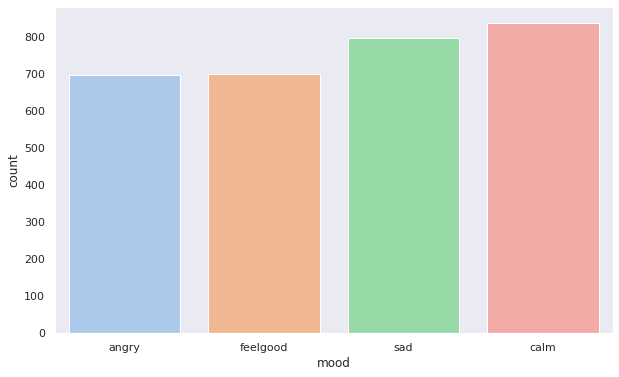

In [9]:
sns.countplot(x=analysis_df['mood'])

Our classes are roughly equally distributed, allowing us to train several models.

In [10]:
plotly_df = analysis_df.groupby('mood')[['acousticness', 'danceability', 'energy', 'valence', 'instrumentalness']].mean()

In [11]:
categories = plotly_df.columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=plotly_df.values[0],
      theta=categories,
      fill='toself',
      name=plotly_df.index[0]
))
fig.add_trace(go.Scatterpolar(
      r=plotly_df.values[1],
      theta=categories,
      fill='toself',
      name=plotly_df.index[1]
))
fig.add_trace(go.Scatterpolar(
      r=plotly_df.values[2],
      theta=categories,
      fill='toself',
      name=plotly_df.index[2]
))
fig.add_trace(go.Scatterpolar(
      r=plotly_df.values[3],
      theta=categories,
      fill='toself',
      name=plotly_df.index[3]
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

The radar plot shows the differences in aufio features for our four moods. Sad and calm are quite close which may negatively impact our model.

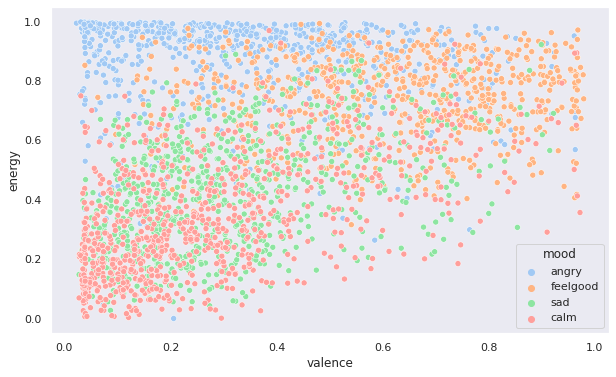

In [ ]:
sns.scatterplot(data=analysis_df, hue='mood', x='valence', y='energy')

An issue that these two plots show is that the "calm" mood should have higher valence(=positivity) if we go by our mood model. This could be an issue with our data. However, as often times the difference between e.g. an acoutic guitar song being positive or negative is part of the lyrics, the perception could be either for anyone.

# 4. Modeling

## 4.1 Preprocessing

### 4.1.1 Sentiment Analysis

To add more depth to our model, we use a small NLP model on the song lyrics to identify moods better. For this, we use the module TextBlob and its Subjectivity and Polarity scores.

In [23]:

def get_subjectivity(text):
  '''
  Getting the Subjectivity using TextBlob
  '''
  return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
  '''
  Getting the Polarity using TextBlob
  '''
  return TextBlob(text).sentiment.polarity

def sentiment_analysis(df, text_col):
  '''
  Perform sentiment analysis on text
  ---
  Input:
  df: Dataframe of interest
  text_col (str): column of interest
  '''
  df['subjectivity'] = df[text_col].apply(get_subjectivity)
  df['polarity'] = df[text_col].apply(get_polarity)
  return df

The sentiment analysis is applied to the original df

In [24]:
sentiment_df = sentiment_analysis(analysis_df, "track_name")
sentiment_df

,id,track_name,artist_name,artist_pop,artist_genres,album,track_pop,valence,energy,danceability,...,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature,mood,subjectivity,polarity
0,1ThimNSQgoMARtEn1Qmyzg,Daltonians,Birds in Row,38,chaotic hardcore,Gris Klein,38,0.3590,0.960,0.392,...,0.02680,0.6160,0,5,95.023,143853,4,angry,0.00,0.00
1,2QDJ3z3tndtFJJo9nJ2lcB,2022,L.S. Dunes,49,dreamo,Past Lives,48,0.4170,0.962,0.325,...,0.02530,0.3670,0,2,178.491,270712,3,angry,0.00,0.00
2,3Nci1QnAWOCUACgs8FdPzE,ego death,foxtails,34,connecticut indie,fawn,23,0.0664,0.727,0.294,...,0.25300,0.5880,0,6,89.930,127938,4,angry,0.00,0.00
3,4hAPiyiwGAlIKP53qfmDuN,Closet,Fleshwater,46,dreamo,We're Not Here to Be Loved,47,0.3860,0.931,0.269,...,0.01840,0.4090,1,11,108.984,122266,4,angry,0.00,0.00
4,7unmH3frGOaKtko1tRnZGV,NYAMA,Backxwash,34,lgbtq+ hip hop,HIS HAPPINESS SHALL COME FIRST EVEN THOUGH WE ...,32,0.1790,0.980,0.486,...,0.00000,0.2610,1,9,130.191,262619,4,angry,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3222,7kzz52nsw2wy0LPQ84ynHE,Every High,Kyson,47,ambient idm,Every High,56,0.1890,0.372,0.702,...,0.01140,0.0972,1,11,114.077,213204,4,calm,0.54,0.16
3223,7CY9cJAnGsp8AYILrnvaRV,Billy,DRAMA,58,indie soul,Gallows,58,0.3870,0.486,0.815,...,0.00124,0.1870,0,8,106.458,211472,4,calm,0.00,0.00
3224,5cvbog6wen3r3bBbcwL16U,We've Never Met but Can We Have a Cup of Coffe...,In Love With a Ghost,54,future bass,Let's Go,56,0.2360,0.214,0.349,...,0.12100,0.3210,0,6,201.128,199604,4,calm,0.00,0.00
3225,2WgDeHNKHm2pjk9ee9eHzB,Together Alone,Nuit Oceān,24,vapor soul,Island -EP,34,0.0908,0.183,0.396,...,0.12500,0.0911,1,2,139.645,185758,4,calm,0.00,0.00


### 4.1.2 Train/test split

In [25]:
X = sentiment_df.drop(["id",'mood', 'artist_name', 'track_name','artist_genres', 'album'], axis=1)
y = sentiment_df['mood']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 11)

### 4.1.3 Scaling the data 

We are scaling numerical features to adhere to the 0-1 scale most features are in. This is optional for the tree-based models.

In [27]:
scaler = MinMaxScaler()

In [28]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##4.2 Random Forest classifier

### 4.2.1 Model creation

In [31]:
m_rf = RandomForestClassifier(n_estimators=300,max_depth=5, random_state=11)

In [32]:
m_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=300, random_state=11)

In [33]:
m_rf.score(X_train, y_train), m_rf.score(X_test, y_test)

(0.7915294117647059, 0.7508232711306256)

In [34]:
y_rf_pred = m_rf.predict(X_test)

In [35]:
m_rf_predictions = m_rf.predict_proba(X_test)
m_rf_predictions

array([[0.1178063 , 0.02744714, 0.79156418, 0.06318238],
       [0.13923302, 0.05092271, 0.67806697, 0.1317773 ],
       [0.03730044, 0.20863918, 0.13699159, 0.6170688 ],
       ...,
       [0.04060818, 0.4337757 , 0.19226651, 0.33334961],
       [0.01726624, 0.26895748, 0.05082322, 0.66295307],
       [0.01859051, 0.84568889, 0.00417793, 0.13154267]])

In [39]:
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

       angry       0.91      0.83      0.86       208
        calm       0.75      0.72      0.74       268
    feelgood       0.70      0.85      0.77       199
         sad       0.66      0.63      0.64       236

    accuracy                           0.75       911
   macro avg       0.76      0.76      0.75       911
weighted avg       0.75      0.75      0.75       911



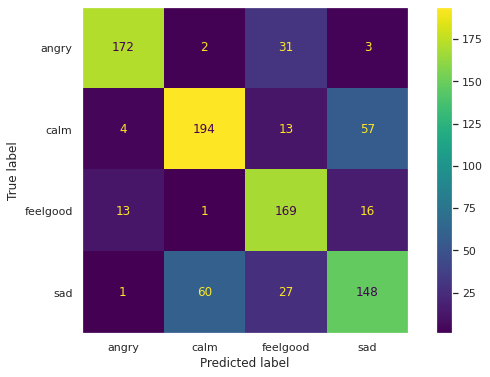

In [22]:
cm = confusion_matrix(y_test, y_rf_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=m_rf.classes_)
disp.plot()

<BarContainer object of 17 artists>

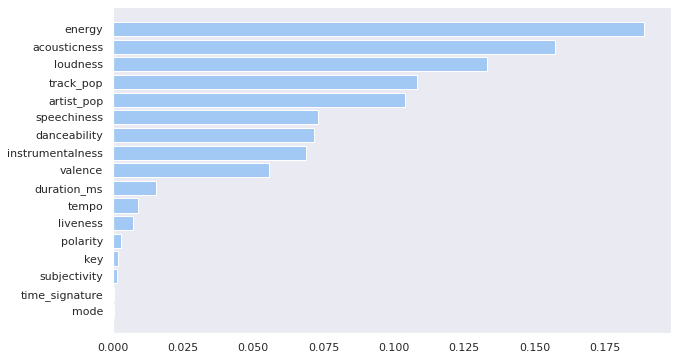

In [23]:
sorted_idx = m_rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], m_rf.feature_importances_[sorted_idx])

In [40]:
#pickle.dump(m_rf, open("m_rf.sav", "wb"))

###4.2.2 GridSearchCV for Random Forest model

In [24]:
grid = GridSearchCV(m_rf,
        param_grid={'max_depth': [2, 3, 5 , 8, 10], 'n_estimators':[50, 100, 200, 300, 500]},
        scoring='accuracy',
        n_jobs=1,
        cv=5,
        return_train_score=True
        )


In [26]:
grid.fit(X_train, y_train)
print("\nbest score      :", grid.best_score_)
print("\nbest score      :", grid.best_params_)



best score      : 0.7590588235294117

best score      : {'max_depth': 10, 'n_estimators': 300}


While the best score supposedly is at 10 depth and 300 estimators, I chose to stick with a max_depth of 5 in the model while taking the 300 n_estimators from the grid search as that model overfit less than the one suggested via gridsearch.

## 4.3 K-Nearest-Neighbors classifier

In [ ]:
m_knn = KNeighborsClassifier(n_neighbors=20)

In [ ]:
m_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=20)

In [ ]:
m_knn.score(X_train_scaled, y_train), m_knn.score(X_test_scaled, y_test)

(0.723764705882353, 0.7156970362239298)

In [ ]:
y_knn_pred = m_knn.predict(X_test_scaled)

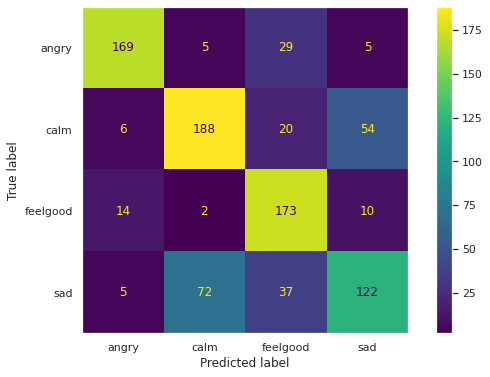

In [ ]:
cm = confusion_matrix(y_test, y_knn_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=m_knn.classes_)
disp.plot()

## 4.4 Support Vector Machines

In [ ]:
clf = SVC(kernel='rbf')

In [ ]:
m_svm = clf.fit(X_train_scaled, y_train)

In [ ]:
m_svm.score(X_train_scaled, y_train), m_svm.score(X_test_scaled, y_test)

(0.7618823529411765, 0.7398463227222832)

In [ ]:
y_svm_pred = m_svm.predict(X_test_scaled)

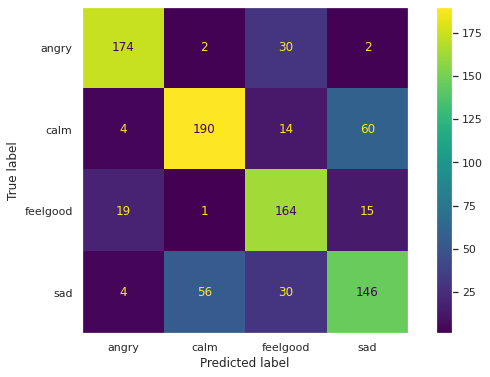

In [ ]:
cm = confusion_matrix(y_test, y_svm_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=m_svm.classes_)
disp.plot()

## 4.5 Naive Bayes

In [ ]:
m_nb = MultinomialNB()

In [ ]:
m_nb.fit(X_train_scaled, y_train)

MultinomialNB()

In [ ]:
m_nb.score(X_train_scaled, y_train), m_nb.score(X_test_scaled, y_test)

(0.648, 0.6794731064763996)

In [ ]:
y_nb_pred = m_nb.predict(X_test_scaled)

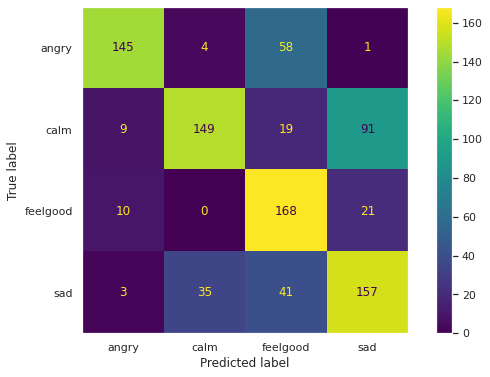

In [ ]:
cm = confusion_matrix(y_test, y_nb_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=m_nb.classes_)
disp.plot()

## 4.6 XGBoost

In [41]:
m_xgb = xgb.XGBClassifier()

In [42]:
m_xgb = m_xgb.fit(X_train, y_train)

In [43]:
m_xgb.score(X_train, y_train), m_xgb.score(X_test, y_test)

(0.8578823529411764, 0.7607025246981339)

In [45]:
y_xgb_pred = m_xgb.predict(X_test)

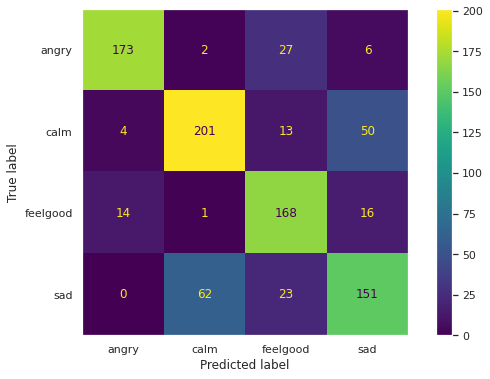

In [46]:
cm = confusion_matrix(y_test, y_xgb_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=m_xgb.classes_)
disp.plot()

<BarContainer object of 17 artists>

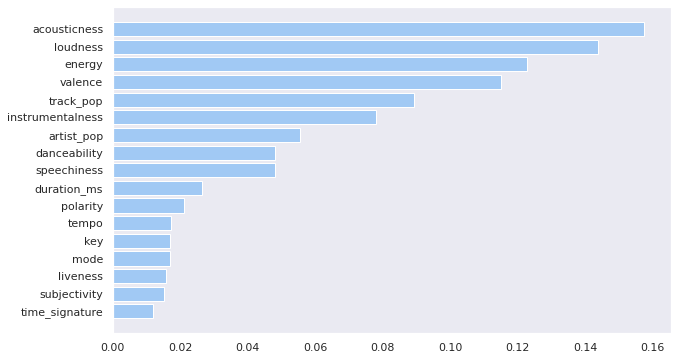

In [47]:
sorted_idx = m_xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], m_xgb.feature_importances_[sorted_idx])

In [48]:
m_xgb.save_model('m_xgb.json')

## 4.7 CatBoost

In [49]:
m_cb = CatBoostClassifier()

In [ ]:
m_cb.fit(X_train, y_train, eval_set=(X_test, y_test))

In [51]:
m_cb.score(X_train, y_train), m_cb.score(X_test, y_test)

(0.9214117647058824, 0.7727771679473107)

In [54]:
y_cb_pred = m_cb.predict(X_test)

In [52]:
m_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,energy,15.633755
1,acousticness,10.919410
2,artist_pop,10.209912
3,instrumentalness,8.779734
4,speechiness,8.701495
5,track_pop,8.474101
6,danceability,7.186396
7,loudness,6.172832
8,duration_ms,5.921011
9,valence,5.846202


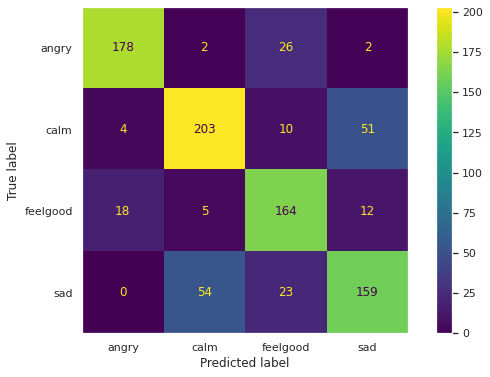

In [55]:
cm = confusion_matrix(y_test, y_cb_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=m_cb.classes_)
disp.plot()

In [ ]:
m_cb.save_model("m_cb.cbm")

## 4.8 Neural Network

Let's attempt to use a neural network for this classification task.

### Preprocessing

In [272]:
K.clear_session()

In [171]:
y_nn = y.map({'angry': 0, 
             'calm':1,
             'feelgood':2,
             'sad':3})


In [172]:
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X.values, y_nn, test_size=0.25)

In [173]:
y_nn_train_true = y_nn_train.copy()
y_nn_test_true = y_nn_test.copy()

In [362]:
y_nn_train = to_categorical(y_nn_train)
y_nn_test = to_categorical(y_nn_test)

In [175]:
X_nn_train_scaled = scaler.fit_transform(X_nn_train)
X_nn_test_scaled = scaler.transform(X_nn_test)

In [176]:
X_nn_train_scaled.shape, y_nn_train.shape

((2277, 17), (2277, 4))

### Simple Multiclass

In [273]:
m_nn = Sequential()
m_nn.add(Dense(17, input_dim = X_nn_train_scaled.shape[1], activation = 'relu'))
m_nn.add(Dense(33, activation = 'relu'))
m_nn.add(Dense(4, activation = 'softmax'))

opt = Adam(learning_rate=0.01)
m_nn.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [271]:
m_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                306       
                                                                 
 dense_1 (Dense)             (None, 16)                288       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 662
Trainable params: 662
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = m_nn.fit(X_nn_train_scaled, y_nn_train, epochs =100, batch_size=1000, validation_split=0.2)

In [275]:
m_nn.evaluate(X_nn_test_scaled,  y_nn_test, verbose=2)

24/24 - 0s - loss: 0.6418 - accuracy: 0.7088 - 51ms/epoch - 2ms/step


[0.6418216824531555, 0.7088273763656616]

In [259]:
y_nn_pred = m_nn.predict(X_nn_test_scaled)

24/24 [==============================] - 0s 1ms/step


In [260]:
y_nn_pred

array([[0.00013347, 0.58382654, 0.00030437, 0.41573566],
       [0.0000191 , 0.9843028 , 0.0000134 , 0.01566467],
       [0.07075106, 0.01242598, 0.8678863 , 0.0489366 ],
       ...,
       [0.00653951, 0.22692232, 0.06989255, 0.6966456 ],
       [0.38257247, 0.00601007, 0.6006746 , 0.01074281],
       [0.01202485, 0.00944634, 0.95665956, 0.02186924]], dtype=float32)

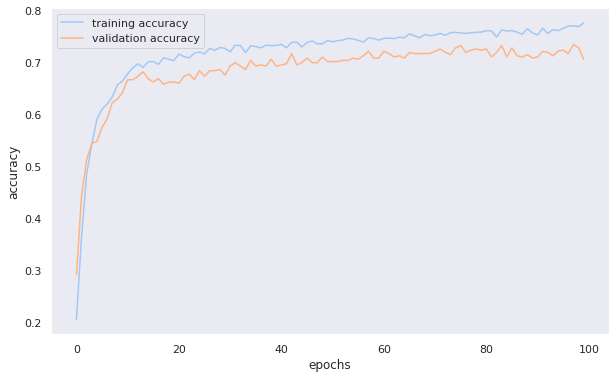

In [276]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

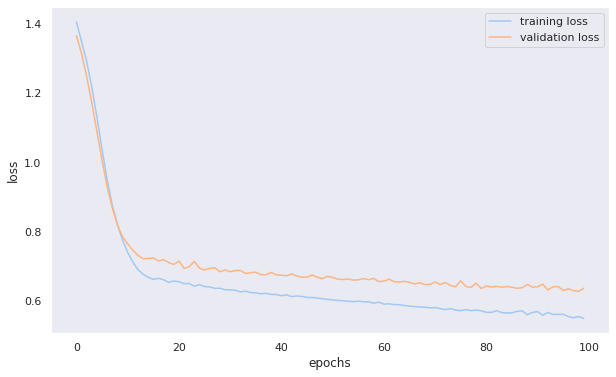

In [277]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

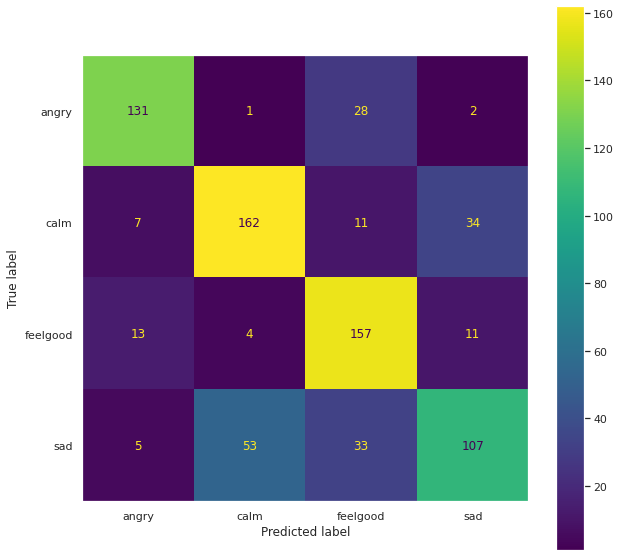

In [278]:
cm = confusion_matrix(y_true=y_nn_test_true, y_pred=np.argmax(y_nn_pred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(y))
fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax)

After training the neural network and tweaking a couple parameters, it does look like even a neural network cannot For this model to perform better, we likely need more and better input data.

## 4.9 Multilabel approach using other models accuracies

No matter waht model we use, we seem to cap out at roughly 75%, which is quite good considering the subjectivity and data quality we analysed earlier. But how do we fare if make this a multilabel problem, allowing for more than one mood per song? For this, we will use out best classification model and use the predict probabilities to figure out, if a song might have more than one mood. We choose a cutoff at 0.3, if the model is less than 70% sure that a mood belongs to a certain song, it might be that there is more than one mood

### 4.9.1 Preprocessing

In [29]:
multilabel_df = X #let's create a new dataframe that we can add the probabilities to

In [36]:
prediction_probas = m_rf.predict_proba(multilabel_df) #add random forest probs

In [37]:
#add columns
multilabel_df["angry_prob"] = prediction_probas[:,0]
multilabel_df["calm_prob"] = prediction_probas[:,1]
multilabel_df["feelgood_prob"] = prediction_probas[:,2]
multilabel_df["sad_prob"] = prediction_probas[:,3]

In [38]:
multilabel_df.head()

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,...,key,tempo,duration_ms,time_signature,subjectivity,polarity,angry_prob,calm_prob,feelgood_prob,sad_prob
0,38,38,0.3590,0.960,0.392,-4.778,0.0908,0.000007,0.0268,0.616,...,5,95.023,143853,4,0.0,0.0,0.918156,0.009940,0.058146,0.013757
1,49,48,0.4170,0.962,0.325,-2.587,0.0448,0.000014,0.0253,0.367,...,2,178.491,270712,3,0.0,0.0,0.570431,0.049737,0.307948,0.071884
2,34,23,0.0664,0.727,0.294,-8.262,0.0406,0.000056,0.2530,0.588,...,6,89.930,127938,4,0.0,0.0,0.739574,0.101454,0.054469,0.104502
3,46,47,0.3860,0.931,0.269,-3.453,0.0905,0.000034,0.0184,0.409,...,11,108.984,122266,4,0.0,0.0,0.841471,0.012433,0.128423,0.017672
4,34,32,0.1790,0.980,0.486,-5.184,0.2780,0.215000,0.0000,0.261,...,9,130.191,262619,4,0.0,0.0,0.696505,0.058195,0.133657,0.111643


In [39]:
# write moods as binary list in a new column
def mood_assign(row):
    moods = []
    if row['angry_prob'] >= 0.30:
      moods.append(1)
    if row['angry_prob'] < 0.30:
      moods.append(0)
    if row['calm_prob'] >= 0.30:
      moods.append(1)
    if row['calm_prob'] < 0.30:
      moods.append(0)
    if row['feelgood_prob'] >= 0.30:
      moods.append(1)
    if row['feelgood_prob'] < 0.30:
      moods.append(0)
    if row['sad_prob'] >= 0.30:
      moods.append(1)
    if row['sad_prob'] < 0.30:
      moods.append(0)
    return moods

In [40]:
multilabel_df['moods'] = multilabel_df.apply(mood_assign, axis=1)

In [41]:
multilabel_df.tail(10)

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,time_signature,subjectivity,polarity,angry_prob,calm_prob,feelgood_prob,sad_prob,moods
3217,60,39,0.1770,0.566,0.703,-5.118,0.0554,0.213,0.02070,0.2120,...,162.063,87037,4,0.00,0.00,0.136552,0.338810,0.242637,0.282000,"[0, 1, 0, 0]"
3218,45,30,0.4590,0.494,0.575,-8.731,0.3720,0.617,0.33700,0.5520,...,167.083,234000,5,0.00,0.00,0.050060,0.589001,0.055371,0.305568,"[0, 1, 0, 1]"
3219,46,54,0.1970,0.375,0.594,-12.110,0.0588,0.725,0.29200,0.1040,...,94.019,324107,4,0.40,0.10,0.031388,0.663694,0.028077,0.276842,"[0, 1, 0, 0]"
3220,58,36,0.1840,0.226,0.560,-19.713,0.1760,0.667,0.44200,0.3490,...,99.850,130271,4,0.00,0.00,0.029214,0.712822,0.022688,0.235277,"[0, 1, 0, 0]"
3221,24,32,0.3400,0.563,0.762,-14.623,0.0872,0.807,0.10900,0.1200,...,103.051,170404,4,0.00,0.00,0.040198,0.680176,0.031225,0.248401,"[0, 1, 0, 0]"
3222,47,56,0.1890,0.372,0.702,-12.298,0.0478,0.629,0.01140,0.0972,...,114.077,213204,4,0.54,0.16,0.023217,0.652439,0.024013,0.300331,"[0, 1, 0, 1]"
3223,58,58,0.3870,0.486,0.815,-7.363,0.0311,0.348,0.00124,0.1870,...,106.458,211472,4,0.00,0.00,0.042659,0.265618,0.232348,0.459375,"[0, 0, 0, 1]"
3224,54,56,0.2360,0.214,0.349,-18.295,0.0538,0.926,0.12100,0.3210,...,201.128,199604,4,0.00,0.00,0.037368,0.661393,0.033226,0.268014,"[0, 1, 0, 0]"
3225,24,34,0.0908,0.183,0.396,-14.871,0.0324,0.784,0.12500,0.0911,...,139.645,185758,4,0.00,0.00,0.020355,0.702971,0.012679,0.263995,"[0, 1, 0, 0]"
3226,14,31,0.0388,0.202,0.711,-15.667,0.0340,0.941,0.08300,0.1140,...,100.043,208200,4,0.00,0.00,0.022175,0.743773,0.010662,0.223390,"[0, 1, 0, 0]"


In [88]:
#Create new X and y for this model
X_ml = multilabel_df.drop(['angry_prob', 'calm_prob', 'feelgood_prob',
       'sad_prob', 'moods'], axis=1)
y_ml = multilabel_df['moods']

In [89]:
X_ml_train, X_ml_test, y_ml_train, y_ml_test = train_test_split(X_ml, y_ml, test_size=0.25)

In [90]:
X_ml_train_scaled = scaler.fit_transform(X_ml_train)
X_ml_test_scaled = scaler.transform(X_ml_test)

In [91]:
y_ml_train_true = y_ml_train.copy()
y_ml_test_true = y_ml_test.copy()

In [93]:
# create an array y instead of being saved in a Series
y_ml_train = list(y_ml_train)
y_ml_train  = np.array(y_ml_train)
y_ml_train 

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 1],
       [1, 0, 0, 0]])

In [94]:
y_ml_test = list(y_ml_test)
y_ml_test  = np.array(y_ml_test)
y_ml_test.shape

(759, 4)

In [95]:
y_ml_train.shape

(2277, 4)

### 4.9.2 Neural Network



In [92]:
input_dim = X_ml_train_scaled.shape[1]

In [96]:
K.clear_session()

In [97]:
# define the model
m_nn_ml = Sequential()
m_nn_ml.add(Dense(17, input_dim=input_dim,activation='relu'))
m_nn_ml.add(Dense(16,activation='relu'))
m_nn_ml.add(Dense(4, activation='sigmoid'))
m_nn_ml.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [98]:
history = m_nn_ml.fit(X_ml_train_scaled, y_ml_train, epochs=200, batch_size=1000, validation_split=0.2, verbose=0)

In [99]:
m_nn_ml.evaluate(X_ml_test_scaled,  y_ml_test, verbose=2)

24/24 - 0s - loss: 0.2295 - accuracy: 0.7945 - 45ms/epoch - 2ms/step


[0.2294793576002121, 0.7944663763046265]

In [100]:
y_nn_ml_pred = m_nn_ml.predict(X_ml_test_scaled)

24/24 [==============================] - 0s 1ms/step


In [101]:
#awesome numbers that go beyond a total of 1 - very nice for cosine similarity
y_nn_ml_pred

array([[0.00479086, 0.02297193, 0.87703675, 0.5812875 ],
       [0.01384311, 0.74780566, 0.11889105, 0.69950914],
       [0.00513373, 0.9877843 , 0.00355321, 0.28110385],
       ...,
       [0.6283249 , 0.00539701, 0.74147755, 0.04757735],
       [0.06146735, 0.0068767 , 0.9442374 , 0.16448142],
       [0.9669057 , 0.05691768, 0.0370831 , 0.00686731]], dtype=float32)

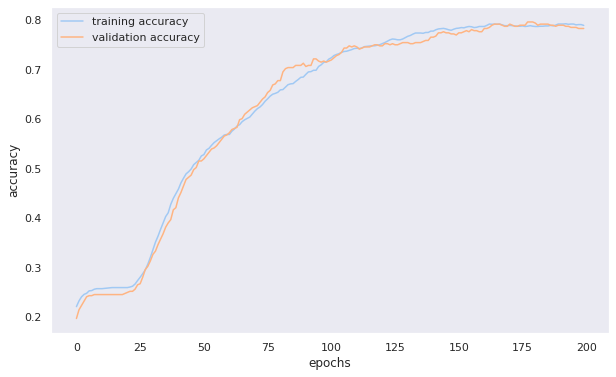

In [102]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

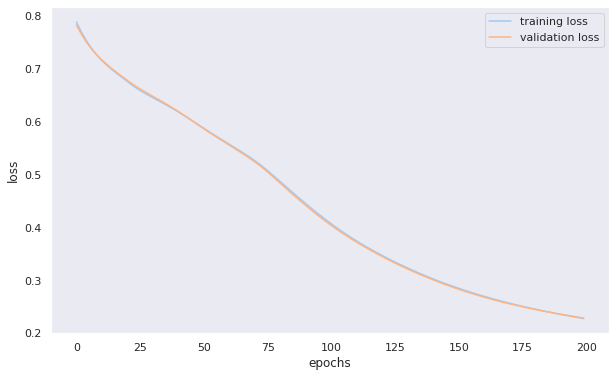

In [103]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

A neural network seems to grasp the multilabels quite well. We finally consistently go through the 75'% threshold. Let's check out a library that is actually made for multilabel classficiation as well.

In [62]:
#pickle.dump(m_nn_ml, open("m_nn_ml.sav", "wb"))

### 4.9.3 BinaryRelevance/One vs. Rest Classifier

In [149]:
m_br = BinaryRelevance(RandomForestClassifier(n_estimators=300,max_depth=5, random_state=11))

In [158]:
m_br.fit(X_ml_train_scaled, y_ml_train)

BinaryRelevance(classifier=RandomForestClassifier(max_depth=5, n_estimators=300,
                                                  random_state=11),
                require_dense=[True, True])

In [142]:
y_br_pred = m_br.predict(X_ml_test_scaled)

In [159]:
m_br.predict_proba(X_ml_test_scaled).toarray()

array([[0.03729806, 0.02605394, 0.87491397, 0.38542689],
       [0.0276548 , 0.79478827, 0.1102217 , 0.69508168],
       [0.02629352, 0.96059567, 0.00827808, 0.15828498],
       ...,
       [0.7436207 , 0.01490285, 0.55108156, 0.00546236],
       [0.04780347, 0.00496053, 0.94757783, 0.0468908 ],
       [0.99424839, 0.01769946, 0.01284047, 0.0141267 ]])

In [161]:
m_br.score(X_ml_train_scaled, y_ml_train), m_br.score(X_ml_test_scaled, y_ml_test)

(0.9060166886253843, 0.8458498023715415)

In [172]:
print(classification_report(y_ml_test, y_br_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       174
           1       0.94      0.91      0.92       289
           2       0.90      0.90      0.90       249
           3       0.89      0.90      0.90       282

   micro avg       0.92      0.90      0.91       994
   macro avg       0.92      0.90      0.91       994
weighted avg       0.92      0.90      0.91       994
 samples avg       0.92      0.92      0.91       994



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.9.4 ClassifierChain

In [119]:
from skmultilearn.problem_transform import ClassifierChain

In [152]:
m_cc = ClassifierChain(classifier=RandomForestClassifier(n_estimators=300,max_depth=5, random_state=11))

In [153]:
m_cc.fit(X_ml_train, y_ml_train)

ClassifierChain(classifier=RandomForestClassifier(max_depth=5, n_estimators=300,
                                                  random_state=11),
                require_dense=[True, True])

In [126]:
m_cc.predict_proba(X_ml_test).toarray()

array([[0.02, 0.02, 0.98, 0.24],
       [0.01, 0.87, 0.01, 0.77],
       [0.  , 0.99, 0.  , 0.1 ],
       ...,
       [0.85, 0.01, 0.6 , 0.  ],
       [0.02, 0.  , 1.  , 0.  ],
       [1.  , 0.01, 0.  , 0.01]])

In [181]:
y_cc_pred = m_cc.predict(X_ml_test)

In [183]:
m_cc.score(X_ml_train, y_ml_train), m_cc.score(X_ml_test, y_ml_test)

(0.9029424681598595, 0.8616600790513834)

In [182]:
print(classification_report(y_ml_test, y_cc_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       174
           1       0.98      0.93      0.95       289
           2       0.95      0.96      0.96       249
           3       0.91      0.94      0.92       282

   micro avg       0.95      0.94      0.94       994
   macro avg       0.96      0.93      0.94       994
weighted avg       0.95      0.94      0.94       994
 samples avg       0.95      0.95      0.94       994



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
pickle.dump(m_cc, open("m_cc.sav", "wb"))

### 4.9.5 LabelPowerset

In [127]:
from skmultilearn.problem_transform import LabelPowerset

In [178]:
m_lp = LabelPowerset(classifier=RandomForestClassifier(n_estimators=300,max_depth=5, random_state=11))

In [179]:
m_lp.fit(X_ml_train_scaled, y_ml_train)

LabelPowerset(classifier=RandomForestClassifier(max_depth=5, n_estimators=300,
                                                random_state=11),
              require_dense=[True, True])

In [180]:
m_lp.score(X_ml_train_scaled, y_ml_train), m_lp.score(X_ml_test_scaled, y_ml_test)

(0.8335529205094423, 0.8129117259552042)

### 4.9.6 Summary

Using a multilabel approach, we were able to get the accuracy finally above 80% for our model. This makes sense, as many tracks are quite close in their sound and a simple multiclass model can only capture one mood per track. Allowing the multilabel to output more than one (technically up to 4, most of the time 2) moods make this model more accurate. This will additionally be more useful for our cosine similarity recommendations because the max vector is not capped at 1 like with the random forest model. We choose the BinaryRelevance model finally for its simplicity and explainability.

## 4.10 Summary



Tree models and SVM with scaled data give us very solid results that we can work with, as roughly 75% of all songs are classified correctly and the largest errors exist between sad and calm which sonically are ofte times very similar.

After running through all models with scaled and unscaled data, most models seemed to not improve using scaled data. Only Support Vector machines doubled its accuracy. Additionally, Naive Bayes was only made possible using scaled (thus non-negative) data, however, it remains our worst model. For simplicity, explainability and performance, we choose the standard random forest classifier going ahead.

# 5. Playground

This section contains debugging code, attempts and other fun that had no place in the real analysis. You can safely ignore this.

## 5.1 Debugging

In [ ]:
analysis_df.groupby('mood').mean()

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature,subjectivity,polarity
mood,,,,,,,,,,,,,,,,,
angry,32.917024,28.666667,0.350446,0.864523,0.387891,-5.559062,0.104723,0.033205,0.273554,0.251375,0.618026,5.197425,129.746715,208453.256080,3.878398,0.120259,-0.013649
calm,46.207390,43.487485,0.279256,0.341577,0.509329,-13.658234,0.049343,0.668452,0.397397,0.136086,0.668653,4.960667,114.439333,226056.486293,3.831943,0.108606,0.030996
feelgood,66.015692,62.562054,0.617092,0.742029,0.647147,-5.888271,0.070057,0.123236,0.037630,0.187921,0.713267,5.407989,122.248354,210602.773181,3.985735,0.157101,0.060478
sad,59.104141,52.398996,0.305924,0.413138,0.510511,-10.088863,0.043417,0.508626,0.090832,0.146982,0.747804,5.173149,116.304518,242709.243413,3.850690,0.160788,0.013206


In [212]:
def get_track_uri(recommender):

  """
  Extracts the track ids of a spotify recommendation api call.
  Returns a list of these ids which can then be used to analyse further.

  """

  id_list = []
  for item in recommender["tracks"]:
    #URI
    track_id = item['id']
    id_list.append(track_id)

  return id_list


    

In [469]:
peaceful_test = sp.recommendations(seed_genres=["indie", "electro", "hip-hop", "pop", "country"], country=None, limit=5, target_valence=0.8, target_energy=0.2)["tracks"]

In [ ]:
peaceful_test

In [457]:
def df_from_recommendations(recs):

  """
  This function returns a dataframe containing track, artist and audio information about songs in a playlist.
  Input: A dictionary with a mood (angry, sad, feelgood, calm) as key and a list of spotify playlist ids as values (e.g 37i9dQZF1DX2n5hpuulC75)


  Warning: As there are several API calls going on (for playlist, tracks, artist and audio features) this function runs for a while. Grab a coffee!
  """




  data_dict = {
    "id":[],  
    "track_name":[], 
    "artist_name":[],
    "artist_pop":[],
    "album":[],
    "track_pop":[],
    "valence":[], 
    "energy":[],
    "danceability":[],
    "loudness" :[],
    "speechiness":[],
    "acousticness":[],
    "instrumentalness":[],
    "liveness":[],
    "mode":[],
    "key":[],
    "tempo":[],
    "duration_ms":[],
    "time_signature":[],
  }


  
  for track in recs:
    
    #Track Id and mood
        data_dict["id"].append(track["id"])
    
    #Track and artist information

        data_dict["track_name"].append(track["name"])
        artist_uri = track["artists"][0]["uri"]
        artist_info = sp.artist(artist_uri)

        data_dict["artist_name"].append(track["artists"][0]["name"])
        data_dict["artist_pop"].append(artist_info["popularity"])
        

        #Album
        data_dict["album"].append(track["album"]["name"])

        #Popularity of the track
        data_dict["track_pop"].append(track["popularity"])
        

        #Audio features
        track_features = sp.audio_features(track["id"])[0]
        data_dict["valence"].append(track_features["valence"])
        data_dict["energy"].append(track_features["energy"])
        data_dict["danceability"].append(track_features["danceability"])
        data_dict["loudness"].append(track_features["loudness"])
        data_dict["speechiness"].append(track_features["speechiness"])
        data_dict["acousticness"].append(track_features["acousticness"])
        data_dict["instrumentalness"].append(track_features["instrumentalness"])
        data_dict["liveness"].append(track_features["liveness"])
        data_dict["mode"].append(track_features["mode"])
        data_dict["key"].append(track_features["key"])
        data_dict["tempo"].append(track_features["tempo"])
        data_dict["duration_ms"].append(track_features["duration_ms"])
        data_dict["time_signature"].append(track_features["time_signature"])


  # Store data in pandas dataframe
  analysis_df = pd.DataFrame(data_dict)

  # Drop duplicates
  analysis_df.drop_duplicates(subset = "id", keep = "first", inplace = True)
  return analysis_df

In [470]:
peaceful_test = df_from_recommendations(peaceful_test)

In [472]:
peaceful_test

,id,track_name,artist_name,artist_pop,album,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature
0,0WrRlCHmD7LzpJa8chDz2h,"Piazza, New York Catcher",Belle and Sebastian,58,Dear Catastrophe Waitress,0,0.833,0.305,0.618,-15.107,0.0372,0.813,0.000000,0.1000,0,3,105.714,183493,4
1,0mG66FLhO0iZ6XCAGdjpax,Elvira,The Oak Ridge Boys,52,Fancy Free,58,0.860,0.285,0.825,-17.491,0.0326,0.188,0.001310,0.0539,1,8,126.946,225627,4
2,333w2F8EjasjzzPOoi2lOe,Okie From Muskogee,Merle Haggard,60,20 Country No 1's,35,0.758,0.371,0.602,-14.033,0.0286,0.640,0.000012,0.2430,1,2,139.664,166000,4
3,0JTQa4Y3jf3Na6PDaUpOuP,About The Trauma Drum,Lyre Le Temps,41,Les Découvertes Du Printemps De Bourges Et De ...,27,0.846,0.444,0.807,-10.624,0.0324,0.258,0.004740,0.1000,0,8,97.992,265187,4
4,2F5lTjxNzxoVP0jRxLSN9Z,All My Rowdy Friends (Have Settled Down),"Hank Williams, Jr.",64,The Pressure Is On,54,0.813,0.542,0.711,-10.319,0.0287,0.230,0.000005,0.2800,1,0,127.002,240373,4


In [473]:
peaceful_x = sentiment_analysis(peaceful_test, "track_name")
peaceful_x = peaceful_test.drop(["id", "track_name", "artist_name", "album"], axis=1)
peaceful_x_scaled = scaler.transform(peaceful_x)
peaceful_x_scaled

array([[0.58      , 0.        , 0.8526626 , 0.30281386, 0.62230417,
        0.50859391, 0.02580645, 0.81626506, 0.        , 0.08771182,
        0.        , 0.27272727, 0.35099727, 0.08970592, 0.75      ,
        0.45454545, 0.56818182],
       [0.52      , 0.59793814, 0.88107767, 0.28272204, 0.85361493,
        0.44688341, 0.0179966 , 0.18875502, 0.00132995, 0.03858041,
        1.        , 0.72727273, 0.4771462 , 0.11635784, 0.75      ,
        0.        , 0.5       ],
       [0.6       , 0.36082474, 0.77373185, 0.36911686, 0.60442508,
        0.5363947 , 0.01120543, 0.64257028, 0.00001168, 0.2401151 ,
        1.        , 0.18181818, 0.5527096 , 0.0786407 , 0.75      ,
        0.        , 0.5       ],
       [0.41      , 0.27835052, 0.86634393, 0.44245201, 0.83350095,
        0.62463761, 0.01765705, 0.25903614, 0.00481218, 0.08771182,
        0.        , 0.72727273, 0.30511737, 0.14138158, 0.75      ,
        0.        , 0.5       ],
       [0.64      , 0.55670103, 0.8316144 , 0.540901

In [474]:
y_pred_peaceful = m_nn_ml.predict(peaceful_x_scaled)
y_pred_peaceful

1/1 [==============================] - 0s 33ms/step


array([[0.00076916, 0.9115733 , 0.05926607, 0.658977  ],
       [0.00067021, 0.30129346, 0.6661469 , 0.5927047 ],
       [0.00103346, 0.6827296 , 0.11585131, 0.69405967],
       [0.00455536, 0.3811346 , 0.5622245 , 0.29243153],
       [0.00815907, 0.10222407, 0.8059305 , 0.3488806 ]], dtype=float32)

In [476]:
peaceful_x['moods_probas'] = list(y_pred_peaceful)
peaceful_x.head(2)

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature,subjectivity,polarity,moods_probas
0,58,0,0.833,0.305,0.618,-15.107,0.0372,0.813,0.00000,0.1000,0,3,105.714,183493,4,0.454545,0.136364,"[0.0007691581, 0.9115733, 0.059266068, 0.658977]"
1,52,58,0.860,0.285,0.825,-17.491,0.0326,0.188,0.00131,0.0539,1,8,126.946,225627,4,0.000000,0.000000,"[0.0006702077, 0.30129346, 0.6661469, 0.5927047]"


In [ ]:
peaceful_vector_df = sentiment_analysis(df_test,'track_name')

In [97]:
vector_df = peaceful_vector_df.drop(["id", "track_name", "artist_name", "album"], axis=1)
vector_df.head(2)

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature,subjectivity,polarity
0,67,60,0.843,0.472,0.865,-7.359,0.237,0.223,0.000054,0.109,0,11,130.011,192029,4,0.8,0.4
1,61,0,0.812,0.578,0.790,-8.753,0.043,0.224,0.920000,0.246,0,7,125.009,165617,4,0.0,0.0


In [108]:
columns_new= ['valence', 'energy', 'danceability', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
plotlysimple_df = vector_df[columns_new]

In [112]:
fig = px.line_polar(plotlysimple_df, r=plotlysimple_df.values.mean(axis=0), theta=columns_new, line_close=True)
fig.update_layout(polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)
fig.show()

In [34]:
X.head(2)

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,mode,key,tempo,duration_ms,time_signature,subjectivity,polarity
0,38,38,0.359,0.960,0.392,-4.778,0.0908,0.000007,0.0268,0.616,0,5,95.023,143853,4,0.0,0.0
1,49,48,0.417,0.962,0.325,-2.587,0.0448,0.000014,0.0253,0.367,0,2,178.491,270712,3,0.0,0.0


In [37]:
prediction_probs = m_rf.predict_proba(vector_df)

In [38]:
# to add prediction probabilities back to df

vector_df['angry'] = prediction_probs[:,0] 
vector_df['calm'] = prediction_probs[:,1]
vector_df['feelgood'] = prediction_probs[:,2]
vector_df['sad'] = prediction_probs[:,3]
vector_df

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,...,key,tempo,duration_ms,time_signature,subjectivity,polarity,angry,calm,feelgood,sad
0,67,60,0.843,0.472,0.865,-7.359,0.2370,0.2230,0.000054,0.1090,...,11,130.011,192029,4,0.8,0.4,0.071428,0.094650,0.705812,0.128110
1,61,0,0.812,0.578,0.790,-8.753,0.0430,0.2240,0.920000,0.2460,...,7,125.009,165617,4,0.0,0.0,0.178100,0.416906,0.240567,0.164428
2,69,73,0.707,0.335,0.940,-10.179,0.5050,0.1700,0.000000,0.2620,...,5,120.040,209640,4,0.0,0.0,0.036249,0.189458,0.490769,0.283525
3,62,0,0.526,0.329,0.791,-12.906,0.0592,0.6000,0.863000,0.1930,...,10,127.021,230500,4,0.0,0.0,0.112244,0.657158,0.035909,0.194689
4,57,64,0.839,0.484,0.836,-7.332,0.3270,0.0454,0.000000,0.0557,...,2,95.941,222933,4,0.0,0.0,0.071621,0.073808,0.725223,0.129349


In [41]:
mood_array = np.array([1,0.3,0.2, 0.6])
mood_array

array([1. , 0.3, 0.2, 0.6])

In [49]:
np.array(vector_df[["angry", "calm", "feelgood", "sad"]])

array([[0.07142846, 0.09464971, 0.70581188, 0.12810995],
       [0.1780998 , 0.41690586, 0.24056657, 0.16442776],
       [0.03624868, 0.189458  , 0.49076874, 0.28352459],
       [0.11224399, 0.65715802, 0.0359085 , 0.19468948],
       [0.07162053, 0.0738078 , 0.72522287, 0.1293488 ]])

In [57]:
vector_df['similarity'] = vector_df[["angry", "calm", "feelgood", "sad"]].apply(lambda row: 1 - cosine(row, mood_array), axis=1)
vector_df

,artist_pop,track_pop,valence,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,time_signature,subjectivity,polarity,angry,calm,feelgood,sad,distance,similarity
0,67,60,0.843,0.472,0.865,-7.359,0.2370,0.2230,0.000054,0.1090,...,192029,4,0.8,0.4,0.071428,0.094650,0.705812,0.128110,0.358138,0.358138
1,61,0,0.812,0.578,0.790,-8.753,0.0430,0.2240,0.920000,0.2460,...,165617,4,0.0,0.0,0.178100,0.416906,0.240567,0.164428,0.683968,0.683968
2,69,73,0.707,0.335,0.940,-10.179,0.5050,0.1700,0.000000,0.2620,...,209640,4,0.0,0.0,0.036249,0.189458,0.490769,0.283525,0.494455,0.494455
3,62,0,0.526,0.329,0.791,-12.906,0.0592,0.6000,0.863000,0.1930,...,230500,4,0.0,0.0,0.112244,0.657158,0.035909,0.194689,0.510526,0.510526
4,57,64,0.839,0.484,0.836,-7.332,0.3270,0.0454,0.000000,0.0557,...,222933,4,0.0,0.0,0.071621,0.073808,0.725223,0.129349,0.348500,0.348500


## 5.2 API tests

In [127]:
sp.search(q='my bloody valentine', type='artist')['artists']['items'][0]['id']

'3G3Gdm0ZRAOxLrbyjfhii5'

In [209]:
user_tracks = sp.current_user_top_tracks(limit=5)

In [216]:
user_tracks['items'][0]['id']

'68AM2DBV5hnIxvrB9qZp1j'

In [217]:
track_ids= []
for i in user_tracks['items']:
    track_ids.append(i['id'])
track_ids

['68AM2DBV5hnIxvrB9qZp1j',
 '7giFF7RUd8K6NTHXcA96NY',
 '1gvGmBd2bVWefyeVZzuRSn',
 '4tRIbLCbaG9QSy0oUg6ecL',
 '5ykzMyjf4Mfi45iy5pyTAG']

In [207]:
user_artists['items'][0]['id']

'6wBUn8gMP85n8dPu6LoUcF'

In [208]:
artist_ids= []
for i in user_artists['items']:
    artist_ids.append(i['id'])
artist_ids

['6wBUn8gMP85n8dPu6LoUcF',
 '0YrtvWJMgSdVrk3SfNjTbx',
 '2BS3fywRW33o5GygfzZaOZ',
 '4YjpqCSDD7zwMQgPYJMqb0',
 '3D4qYDvoPn5cQxtBm4oseo']

In [218]:
sp.recommendations(seed_tracks=['68AM2DBV5hnIxvrB9qZp1j'], country='DE')

{'tracks': [{'album': {'album_type': 'ALBUM',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4AgusFXPk24LCGMMplX34M'},
      'href': 'https://api.spotify.com/v1/artists/4AgusFXPk24LCGMMplX34M',
      'id': '4AgusFXPk24LCGMMplX34M',
      'name': 'Palehound',
      'type': 'artist',
      'uri': 'spotify:artist:4AgusFXPk24LCGMMplX34M'}],
    'external_urls': {'spotify': 'https://open.spotify.com/album/5P2p0I86dThJcVAhMwLGlh'},
    'href': 'https://api.spotify.com/v1/albums/5P2p0I86dThJcVAhMwLGlh',
    'id': '5P2p0I86dThJcVAhMwLGlh',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/image/ab67616d0000b27399751f171151a86a1392a87d',
      'width': 640},
     {'height': 300,
      'url': 'https://i.scdn.co/image/ab67616d00001e0299751f171151a86a1392a87d',
      'width': 300},
     {'height': 64,
      'url': 'https://i.scdn.co/image/ab67616d0000485199751f171151a86a1392a87d',
      'width': 64}],
    'name': "A Place I'll Always Go",
    'release_d